In [19]:
import numpy as np
from sklearn.ensemble import IsolationForest as IForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle
import torch
import torch.nn as nn
from global_var import *
from normalize import *
from utils import *
from data_load import load_data
from AE import AutoEncoder
from VAE import VAE
import ExtBound
import KITree
import importlib

In [15]:
dataset = 'toniot_custom'
subset = 'ddos'

In [25]:
subset_list = ['Tuesday', 'Wednesday', 'Thursday', 'Friday']
count_list = []
for subset in subset_list:
    df = pd.read_csv(os.path.join('/home/lry/pythondata/venv/lry/dataset', 'CICIDS-2017', f'{subset}.csv'))
    # only include two web servers' external comms
    cond = df['dest-ip'].isin(CICIDS_SERVER_IPS)
    df = df[cond | (df[CUSTOM_LABEL_COL] != 0)]
    df = df[CUSTOM_TUPLE_COLS]
    s = set()
    for i, row in df.iterrows():
        s.add(tuple(row.to_list()))
    count_list.append(len(s))
    print(subset, len(s))
print('average', np.mean(count_list))

Tuesday 8664
Wednesday 17320
Thursday 12122
Friday 48327
average 21608.25


In [21]:
subset_list = ['Tuesday', 'Wednesday', 'Thursday', 'Friday']
s = set()
for subset in subset_list:
    df = pd.read_csv(os.path.join('/home/lry/pythondata/venv/lry/dataset', 'CICIDS-2017', f'{subset}.csv'))
    # only include two web servers' external comms
    cond = df['dest-ip'].isin(CICIDS_SERVER_IPS)
    df = df[cond | (df[CUSTOM_LABEL_COL] != 0)]
    df = df[CUSTOM_TUPLE_COLS]
    for i, row in df.iterrows():
        s.add(tuple(row.to_list()))
    print(subset)
print('sum', len(s))

Tuesday
Wednesday
Thursday
Friday
sum 73588


In [30]:
subset_list = ['backdoor', 'dos', 'ddos', 'mitm', 'injection', 'password', 'runsomware', 'scanning', 'xss']
count_list = []
for subset in subset_list:
    df = pd.read_csv(os.path.join('/home/lry/pythondata/venv/lry/dataset', 'TON-IoT', f'{subset}.csv'))
    df_att = df[df['label'] == 1]
    df_list = [df_att]
    for f in os.listdir(os.path.join('/home/lry/pythondata/venv/lry/dataset', 'TON-IoT')): 
        if f.startswith('normal'):
            df_norm = pd.read_csv(os.path.join('/home/lry/pythondata/venv/lry/dataset', 'TON-IoT', f))#CUSTOM_DATA_DIR
            cond = df_norm['src_ip'].isin(['3.122.49.24']) | df_norm['dst_ip'].isin(['3.122.49.24']) # TONIOT_IPS
            df_norm = df_norm[cond]
            df_list.append(df_norm)
    df = pd.concat(df_list)
    df = df[['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto']]
    s = set()
    for i, row in df.iterrows():
        s.add(tuple(row.to_list()))
    count_list.append(len(s))
    print(subset, len(s))
print('average', np.mean(count_list))

backdoor 16756
dos 2487
ddos 81116
mitm 155
injection 110186
password 95500
runsomware 2431
scanning 71597
xss 104232
average 53828.88888888889


In [18]:
result = []
for dataset, subset in zip(['cicids_custom', 'toniot_custom'], ['Wednesday', 'ddos']):
    X, _, y, _ = load_data(dataset, subset, mode='train')
    X = X[y == 0]
    y = y[y == 0]
    with open(os.path.join(NORMALIZER_DIR, f'{dataset}_{subset}.norm'), 'rb') as f:
        normalizer = pickle.load(f)
    X = normalizer.transform(X)
    for blackbox in ['AE', 'VAE', 'OCSVM', 'IForest']:
        if blackbox == "VAE" or blackbox == "AE":
            model = torch.load(os.path.join(TARGET_MODEL_DIR, f'{blackbox}_{dataset}_{subset}.model')).cuda(DEVICE)
            model.eval()
            score = model.score_samples(X)
            thres = model.thres
            func = lambda x: model.score_samples(x)
        else:
            with open(os.path.join(TARGET_MODEL_DIR, f'{blackbox}_{dataset}_{subset}.model'), 'rb') as f:
                model = pickle.load(f)
            score = -model.score_samples(X)
            thres = -model.offset_
            func = lambda x: -model.score_samples(x)
        kdt = KITree.KITree(func, thres)
        kdt.fit(X, score)
        rule_num = kdt.get_rule_num()
        print(dataset, blackbox, rule_num)
        result.append({
            'dataset': dataset,
            'model': blackbox,
            'rule_num': rule_num
        })
pd.DataFrame(result).to_csv('../result/rule_num.csv', index=False)

cicids_custom AE 17
cicids_custom VAE 27
cicids_custom OCSVM 25
cicids_custom IForest 15
toniot_custom AE 29
toniot_custom VAE 27
toniot_custom OCSVM 17
toniot_custom IForest 17


In [16]:
X, _, y, _ = load_data(dataset, subset, mode='train')
X = X[y == 0]
y = y[y == 0]
X_test, y_test = load_data(dataset, subset, mode='test')
print(X.shape[0], X_test.shape[0])

72 25


In [5]:
def print_metrics(y_true, y_pred, y_model):
    prec, rec, f1 = precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
    fid = (y_pred == y_model).sum() / y_pred.shape[0]
    tpr = TP(y_true, y_pred) / (y_true == 1).sum()
    tnr = TN(y_true, y_pred) / (y_true == 0).sum()
    print('prec:', prec, 'rec:', rec, 'f1:', f1, 'tpr', tpr, 'tnr', tnr, 'fid:', fid)
    return prec, rec, f1, tpr, tnr, fid

In [10]:
with open(os.path.join(TARGET_MODEL_DIR, f'OCSVM_{dataset}_{subset}.model'), 'rb') as f:
    model_SVM = pickle.load(f)
with open(os.path.join(NORMALIZER_DIR, f'{dataset}_{subset}.norm'), 'rb') as f:
    normalizer_SVM = pickle.load(f)
X_SVM = normalizer_SVM.transform(X)
X_test_SVM = normalizer_SVM.transform(X_test)

In [11]:
score_SVM = -model_SVM.score_samples(X_SVM)
thres_SVM = -model_SVM.offset_
func_SVM = lambda x: -model_SVM.score_samples(x)
thres_SVM

array([-0.07413864])

In [12]:
y_model = model_SVM.predict(X_test_SVM)
y_model[y_model == 1] = 0
y_model[y_model == -1] = 1

In [13]:
kdt_SVM = KITree.KITree(func_SVM, thres_SVM)
kdt_SVM.fit(X_SVM, score_SVM)

In [8]:
y_pred = kdt_SVM.predict(X_test_SVM)
print(TP(y_test, y_pred) / (y_test == 1).sum(), FP(y_test, y_pred) / (y_test == 0).sum())

1.0 0.0260950605778192


In [16]:
print_metrics(y_test, y_pred, y_model)

prec: 0.9995757640035757 rec: 1.0 f1: 0.9997878369981967 tpr 1.0 tnr 0.9739049394221808 fid: 0.987948572621782


(0.9995757640035757,
 1.0,
 0.9997878369981967,
 1.0,
 0.9739049394221808,
 0.987948572621782)

In [19]:
kdt_SVM.get_rule_num()

17

In [18]:
kdt_SVM.get_rules_dict(CUSTOM_FEAT_COLS, normalizer_SVM)

{('dim 18 feat iat_var <= 0.05657056090172502',
  'dim 6 feat ps_var <= 107714.33238059204',
  'dim 1 feat fwd_count <= 214.16360655737705',
  'dim 1 feat fwd_count <= 214.16360655737705',
  'dim 1 feat fwd_count <= 214.16360655737705'): array([[ -3.60963042,   0.94751002],
        [ -3.4889819 ,          inf],
        [ -3.13826902,   1.57557226],
        [ -1.47033155,   0.27345199],
        [ -3.69700797,   0.32917795],
        [ -0.15735365,   0.08715156],
        [ -2.53280126,          inf],
        [ -1.07482481,   1.23343794],
        [ -1.12376911,   1.13009366],
        [ -0.15995885,   0.13914843],
        [ -1.06336758,   1.34316591],
        [ -1.10095138,   0.90145678],
        [ -1.06660459,   1.29381951],
        [ -0.16197631,   0.26697538],
        [ -0.92256689,   0.98533384],
        [ -0.3465743 ,   0.3124802 ],
        [ -0.63297144,   1.63887199],
        [ -0.21308095,   0.03747945],
        [ -0.3572944 ,          inf],
        [ -0.63710234,   0.87765754],
   

In [30]:
idx = np.where((kdt_SVM.predict(X_test_SVM) == 1) & (y_test == 0))[0][0]
kdt_SVM.predict_rule_out(X_test_SVM[idx], normalizer_SVM, CUSTOM_FEAT_COLS)

([{'feature_id': 18,
   'feature_name': 'iat_var',
   'comparison': '>',
   'value': 0.132809372672037,
   'threshold': 0.05657056090172502}],
 [{'feature_id': 0,
   'feature_name': 'count',
   'comparison': '>',
   'value': 445.0,
   'threshold': 0.05657056090172502},
  {'feature_id': 1,
   'feature_name': 'fwd_count',
   'comparison': '>',
   'value': 228.0,
   'threshold': 0.05657056090172502},
  {'feature_id': 2,
   'feature_name': 'bwd_count',
   'comparison': '>',
   'value': 217.0,
   'threshold': 0.05657056090172502},
  {'feature_id': 3,
   'feature_name': 'ps_mean',
   'comparison': '>',
   'value': 268.12134831460673,
   'threshold': 0.05657056090172502},
  {'feature_id': 4,
   'feature_name': 'ps_max',
   'comparison': '>',
   'value': 2948.0,
   'threshold': 0.05657056090172502},
  {'feature_id': 5,
   'feature_name': 'ps_min',
   'comparison': '>',
   'value': 52.0,
   'threshold': 0.05657056090172502},
  {'feature_id': 6,
   'feature_name': 'ps_var',
   'comparison': '>='

In [79]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
dataset = 'cicids_custom'
subset = 'Thursday'
X_tree, y_tree = load_data(dataset, subset, mode='test')
_, X_tree_test, _, y_tree_test = load_data(dataset, subset, mode='train')
update_idx = X_tree.shape[0] - int(X_tree.shape[0] * 0.1)
X_tree.shape[0], X_tree.shape[0] - update_idx

(2462, 246)

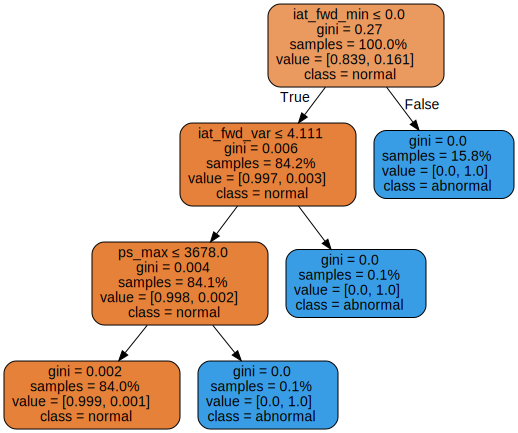

In [84]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_tree, y_tree)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=CUSTOM_FEAT_COLS,  
                                class_names=['normal', 'abnormal'],  
                                filled=True, rounded=True, proportion=True,
                                special_characters=True)  
graph = graphviz.Source(dot_data)   
graph.render('../result/dt_original')
graph

In [81]:
false_idx = (clf.predict(X_tree_test) != y_tree_test)
X_tree_new = np.concatenate([X_tree, X_tree_test[false_idx]])
y_tree_new = np.concatenate([y_tree, y_tree_test[false_idx]])
false_idx.sum() / X_tree.shape[0]

0.002437043054427295

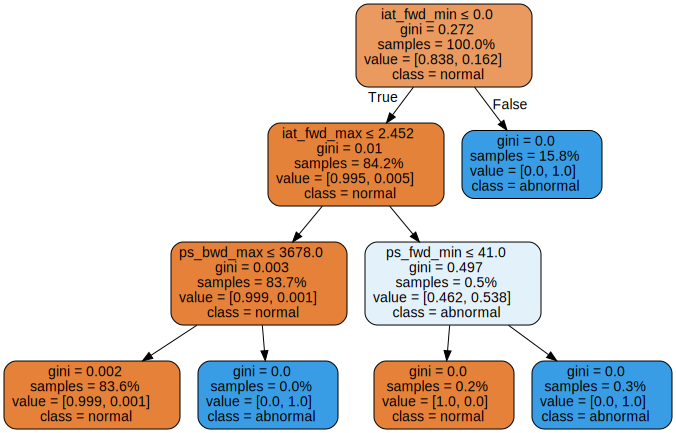

In [85]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_tree_new, y_tree_new)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=CUSTOM_FEAT_COLS,  
                                class_names=['normal', 'abnormal'],  
                                filled=True, rounded=True, proportion=True,
                                special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render('../result/dt_update')
graph